# XBEACH declarative example

In this notebook we will define a XBEACH workspace entirely from yaml file

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import yaml
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Instantiate model

Use a fully-defined config from yaml to instantiate ModelRun with the runtime parameters
and the config definition

In [3]:
# Uncoment below to view the contents of the yaml file

# !cat example_declarative.yml

In [4]:
from rompy.model import ModelRun

conf = yaml.load(open("example_declarative.yml"), Loader=yaml.Loader)
modelrun = ModelRun(**conf)

## QC config

Plot model grid and data to QC before generating the workspace

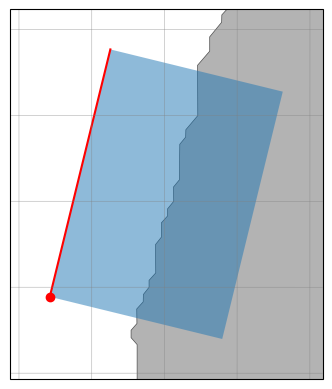

In [5]:
# Model grid

ax = modelrun.config.grid.plot(scale="f")

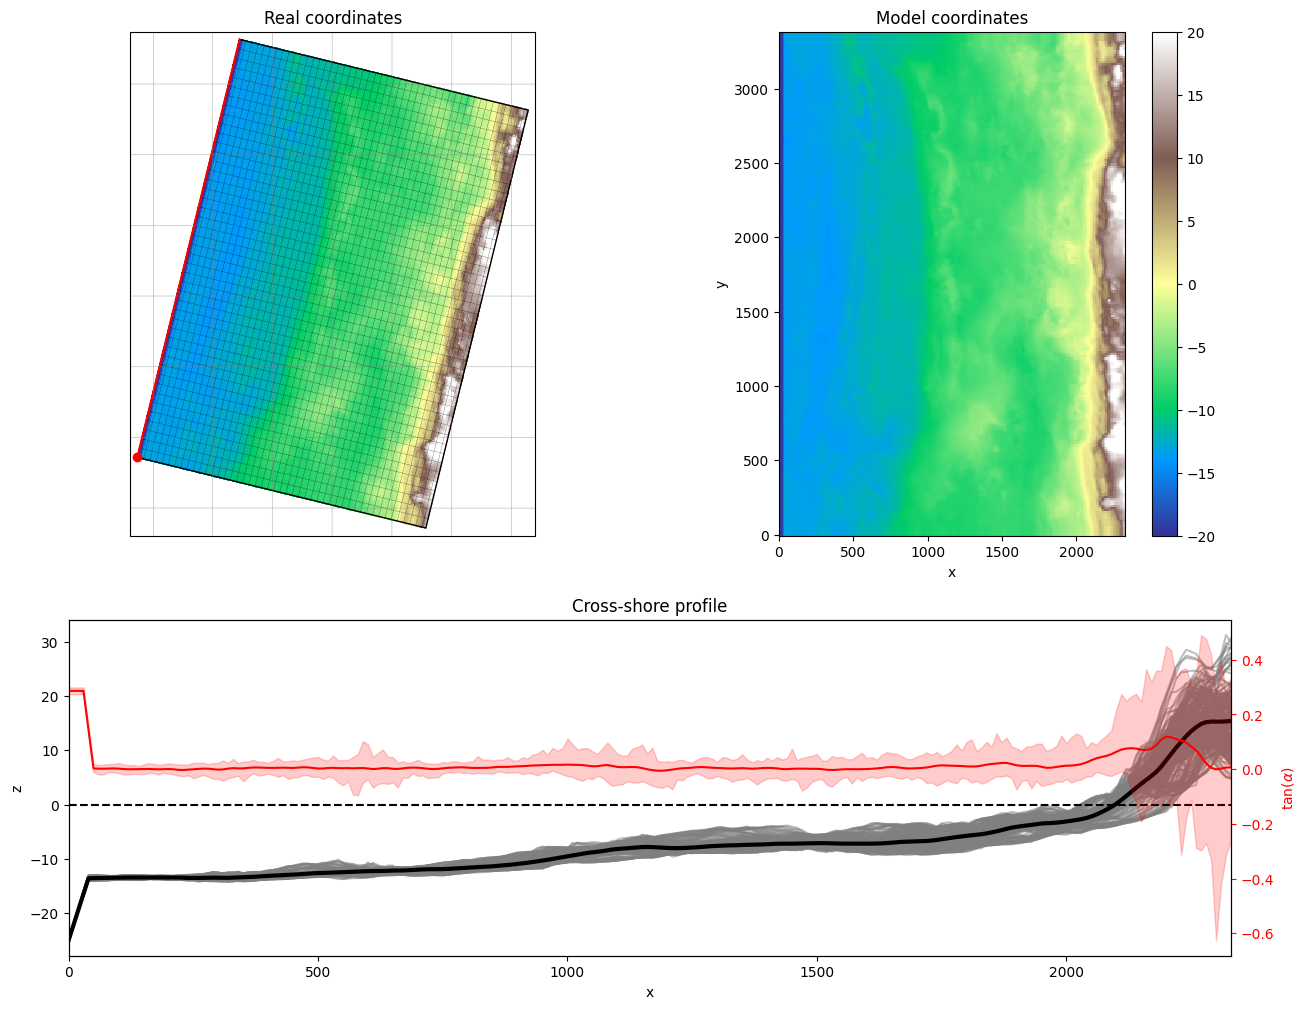

In [6]:
# Model bathy

tmpdir = Path("tmp")
tmpdir.mkdir(exist_ok=True)

# Generate the bathymetry data
xfile, yfile, depfile, grid_extended = modelrun.config.bathy.get(
    destdir=tmpdir, grid=modelrun.config.grid
)

# Load the bathymetry data
dset = xr.Dataset.xbeach.from_xbeach(depfile, grid_extended)

# Plot the bathymetry data
dset.xbeach.plot_model_bathy(grid_extended, posdwn=False)

## Generate the workspace

In [7]:
modelrun()

2025-10-02 13:26:16 [INFO] rompy.model         : ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
2025-10-02 13:26:16 [INFO] rompy.model         : ┃                      MODEL RUN CONFIGURATION                       ┃
2025-10-02 13:26:16 [INFO] rompy.model         : ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
2025-10-02 13:26:16 [INFO] rompy.model         :             Run ID : run1
2025-10-02 13:26:16 [INFO] rompy.model         :         Model Type : Config
2025-10-02 13:26:16 [INFO] rompy.model         :         Start Time : 2023-01-01T00:00:00
2025-10-02 13:26:16 [INFO] rompy.model         :           End Time : 2023-01-02T00:00:00
2025-10-02 13:26:16 [INFO] rompy.model         :           Duration : 1 day
2025-10-02 13:26:16 [INFO] rompy.model         :      Time Interval : 0:00:01
2025-10-02 13:26:16 [INFO] rompy.model         :   Output Directory : example-declarative
2025-10-02 13:26:16 [INFO] rompy.model         : ┏━━━━━━━━━━━━━━

'/source/csiro/rompy-notebooks/notebooks/xbeach/example-declarative/run1'

## Check the workspace

In [8]:
modeldir = Path(modelrun.output_dir) / modelrun.run_id

sorted(modeldir.glob("*"))

[PosixPath('example-declarative/run1/bathy.txt'),
 PosixPath('example-declarative/run1/jonstable-20230101T000000-20230102T000000.txt'),
 PosixPath('example-declarative/run1/params.txt'),
 PosixPath('example-declarative/run1/tide-20230101T000000-20230102T000000.txt'),
 PosixPath('example-declarative/run1/wind-20230101T000000-20230102T000000.txt'),
 PosixPath('example-declarative/run1/xdata.txt'),
 PosixPath('example-declarative/run1/ydata.txt')]

In [9]:
params = modeldir / "params.txt"
print(params.read_text())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%% XBeach parameter settings input file
%%%
%%% Date: 2025-10-02 00:26:16.327971+00:00
%%% User: rguedes-XPS-13-9350
%%% Template: /source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

zs0 = 0.0
front = abs_2d
back = abs_2d
left = neumann
right = neumann
lateralwave = wavecrest
break = roelvink_daly
scheme = warmbeam
order = 1
random = 1
hmin = 0.01
wci = 0
alpha = 1.0
delta = 0.0
n = 10.0
rho = 1025.0
g = 9.81
thetamin = -80.0
thetamax = 80.0
dtheta = 10.0
beta = 0.1
roller = 1
gamma = 0.55
gammax = 1.0
sedtrans = 0
morfac = 1.0
morphology = 0
cf = 0.01
eps = 0.01
epsi = 0.001
cfl = 0.8
umin = 0.1
oldhu = 1
outputformat = netcdf
ncfilename = xboutput_test.nc
tstart = 0.0
tintm = 3600.0
paulrevere = land
tstop = 86400.0
tunits = seconds since 2023-01-01 00:00:00
wbctype = jonstable
bcfile = jonstable-20230101T000000-20230102T0000

## Check the input

In [10]:
def read_xbeach_input(modelrun: ModelRun, filetype: str, cols: list[str]) -> pd.DataFrame:
    """Read XBeach input file."""
    filename = Path(modelrun.output_dir) / modelrun.run_id / modelrun.config.namelist[filetype]
    df = pd.read_csv(filename, header=None, sep="\s+", names=cols)
    if "tsec" in cols:
        df.index = [modelrun.period.start + timedelta(seconds=s) for s in df.tsec]
    elif "duration" in cols:
        df.index = pd.date_range(modelrun.period.start, periods=df.shape[0], freq=f"{df.duration.iloc[0]}s")
    return df


def plot_xbeach_input(df, cols):
    fig, axs = plt.subplots(len(cols), 1, figsize=(15, 2.5*len(cols)))
    if len(cols) == 1:
        axs = [axs]
    for ax, col in zip(axs, cols):
        ax.plot(df.index, df[col], "k", linewidth=2)
        ax.set_ylabel(col)
        ax.grid()
        if col != cols[-1]:
            ax.set_xticklabels([])
        ax.set_xlim(df.index[0], df.index[-1])

### Wave boundary

,hm0,tp,mainang,gammajsp,s,duration,dtbc
2023-01-01 00:00:00,0.875435,13.1659,251.114,2.68225,21.95140,3600,1
2023-01-01 01:00:00,0.909496,13.1292,251.203,2.71106,22.14170,3600,1
2023-01-01 02:00:00,0.802303,14.8497,259.002,3.33514,37.51500,3600,1
2023-01-01 03:00:00,0.869525,14.4893,258.311,3.04059,32.56840,3600,1
2023-01-01 04:00:00,0.950949,15.9315,261.311,3.07464,34.76650,3600,1
2023-01-01 05:00:00,1.116260,15.5877,259.663,2.69405,31.39360,3600,1
2023-01-01 06:00:00,1.248320,15.3719,258.318,2.43367,29.18680,3600,1
2023-01-01 07:00:00,1.291500,15.2017,258.212,2.38952,29.76960,3600,1
2023-01-01 08:00:00,1.320870,15.0475,258.130,2.34202,29.70590,3600,1
2023-01-01 09:00:00,1.347160,14.9010,258.004,2.27363,30.11310,3600,1


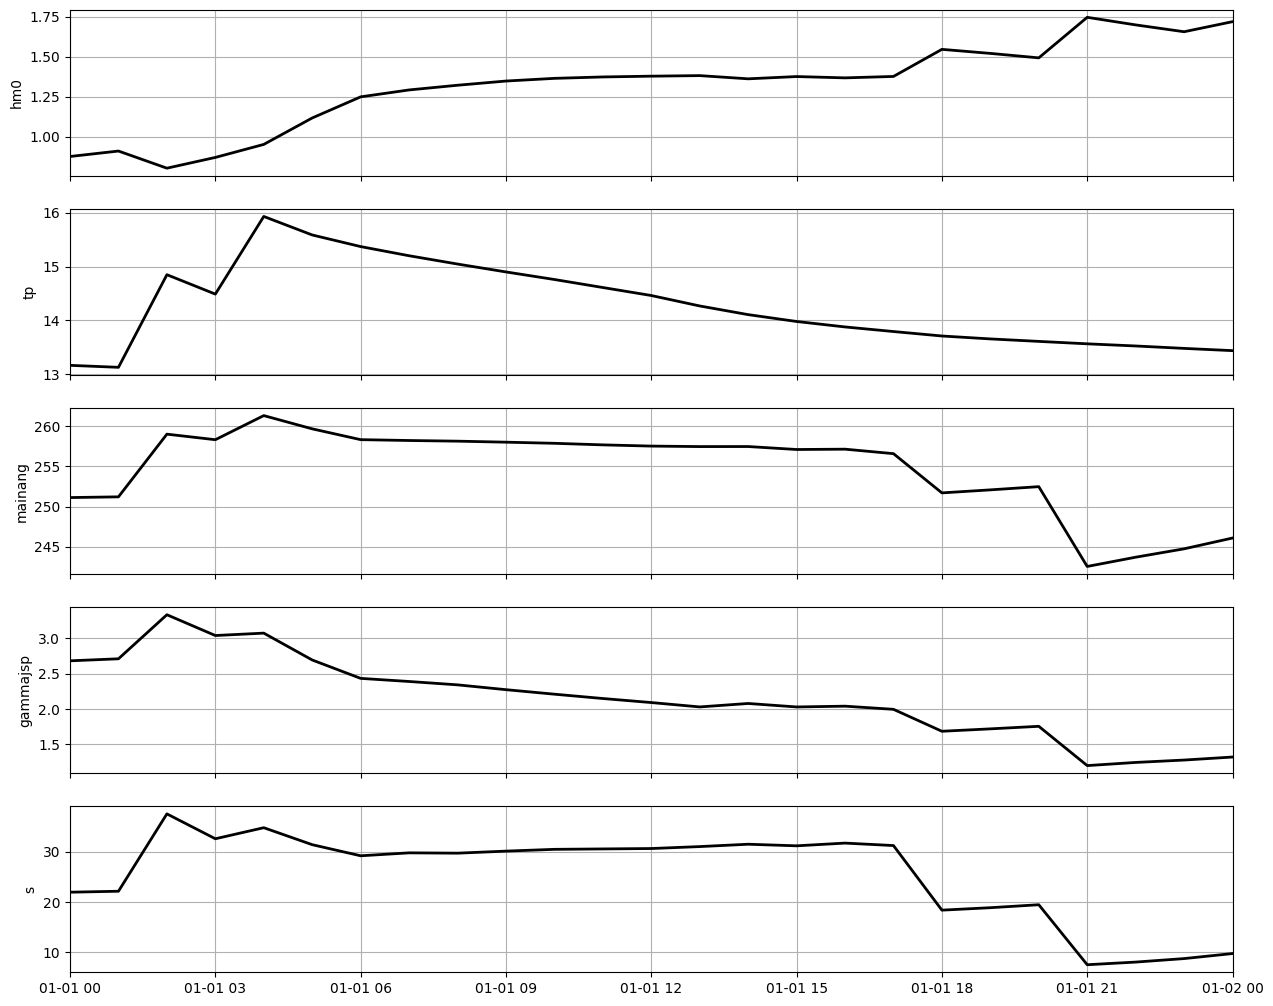

In [11]:
df = read_xbeach_input(modelrun, "bcfile", ["hm0", "tp", "mainang", "gammajsp", "s", "duration", "dtbc"])
display(df)
plot_xbeach_input(df, ["hm0", "tp", "mainang", "gammajsp", "s"])

### Wind

,tsec,wspd,wdir
2023-01-01 00:00:00,0.0,7.15,186.92
2023-01-01 01:00:00,3600.0,7.49,192.82
2023-01-01 02:00:00,7200.0,7.96,198.03
2023-01-01 03:00:00,10800.0,8.24,203.33
2023-01-01 04:00:00,14400.0,8.91,208.57
2023-01-01 05:00:00,18000.0,9.69,210.79
2023-01-01 06:00:00,21600.0,10.09,210.59
2023-01-01 07:00:00,25200.0,10.29,210.61
2023-01-01 08:00:00,28800.0,10.20,209.83
2023-01-01 09:00:00,32400.0,10.26,209.25


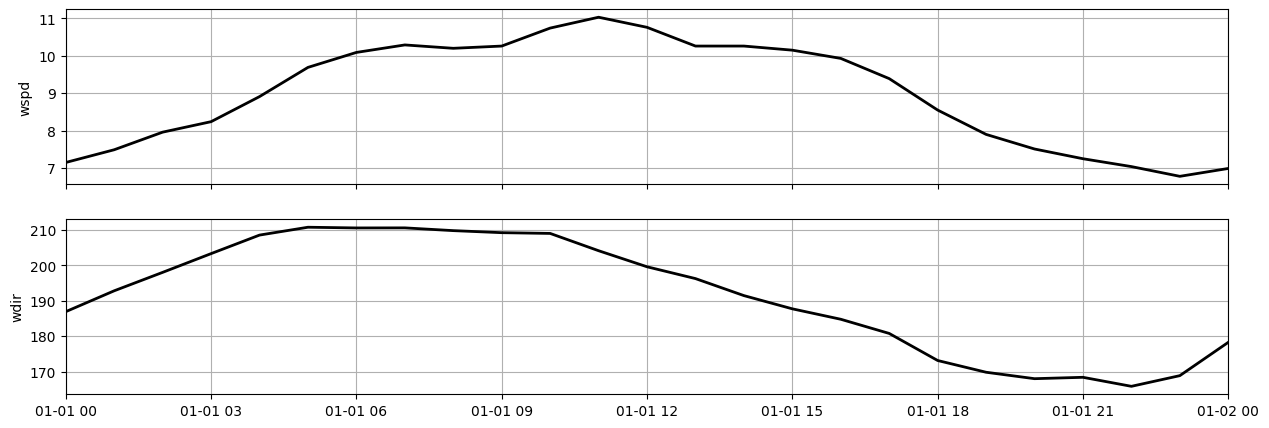

In [12]:
df = read_xbeach_input(modelrun, "windfile", ["tsec", "wspd", "wdir"])
display(df)
plot_xbeach_input(df, ["wspd", "wdir"])

### Tide

,tsec,zs
2023-01-01 00:00:00,0.0,-0.12
2023-01-01 01:00:00,3600.0,-0.10
2023-01-01 02:00:00,7200.0,-0.07
2023-01-01 03:00:00,10800.0,-0.04
2023-01-01 04:00:00,14400.0,0.00
2023-01-01 05:00:00,18000.0,0.05
2023-01-01 06:00:00,21600.0,0.09
2023-01-01 07:00:00,25200.0,0.14
2023-01-01 08:00:00,28800.0,0.17
2023-01-01 09:00:00,32400.0,0.20


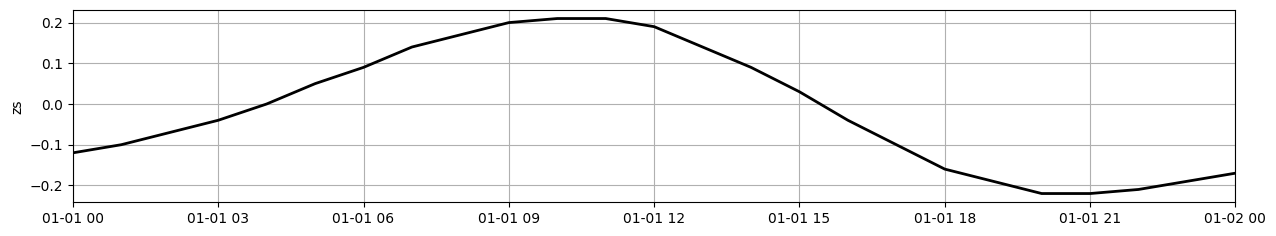

In [13]:
df = read_xbeach_input(modelrun, "zs0file", ["tsec", "zs"])
display(df)
plot_xbeach_input(df, ["zs"])

## Run the model

To be implemented

## Plot outputs

To be implemented

## Cleanup

Uncomment below to clean up the test workspace directory

In [14]:
# import shutil

# shutil.rmtree(run.output_dir, ignore_errors=True)